In [65]:
### Installing the required packages 

!pip install pandas
!pip install quandl
!pip install matplotlib
!pip install yfinance
!pip install python-dotenv

In [103]:
import pandas as pd 
import os
import quandl
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from dotenv import load_dotenv


In [44]:
###loading the .env environment variables

load_dotenv()

True

In [45]:
## getting the environment variables
q_API_KEY = os.getenv('QUANDL_API_KEY')


In [108]:
## setting the API key
quandl.ApiConfig.api_key = q_API_KEY

In [122]:
## getting unemployment data during the gulf war

gulf_unemp_df = quandl.get(["FRED/UNRATE", "FRED/UNEMPLOY"], trim_start = "1990-02-1", trim_end="1991-02-28", collapse = 'monthly')
gulf_unemp_df.columns = ['Gulf_unemploy_rate', 'Gulf_unemploy_level']


gulf_unemp_df

,Gulf_unemploy_rate,Gulf_unemploy_level
Date,,
1990-02-28,5.3,6651.0
1990-03-31,5.2,6598.0
1990-04-30,5.4,6797.0
1990-05-31,5.4,6742.0
1990-06-30,5.2,6590.0
1990-07-31,5.5,6922.0
1990-08-31,5.7,7188.0
1990-09-30,5.9,7368.0
1990-10-31,5.9,7459.0


In [123]:
## getting unemployment data 6 months before the Russia/Ukraine Invasion to date

current_date = date.today()

rus_unemp_df = quandl.get(["FRED/UNRATE", "FRED/UNEMPLOY"], trim_start = "2021-09-1", trim_end=current_date, collapse = 'monthly')
rus_unemp_df.columns = ['rus_unemploy_rate', 'rus_unemploy_level']

rus_unemp_df


,rus_unemploy_rate,rus_unemploy_level
Date,,
2021-09-30,4.7,7666.0
2021-10-31,4.6,7375.0
2021-11-30,4.2,6802.0
2021-12-31,3.9,6319.0
2022-01-31,4.0,6513.0


In [124]:
## function to graph data 

def plot_graph(df, title:str, y_label: str):
    
        ## graphing the data

    cols =[col for col in df.columns]

    fig,ax = plt.subplots(1,1, figsize = (14,6))
    plt.style.use('seaborn')

    for c in cols: 
        ax.plot(c, linewidth=2, data=df)
        ax.set_title(title)
        plt.xlabel('Date')
        plt.ylabel(y_label)

        handles,labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='upper left', prop = {"size":10})

    plt.show()

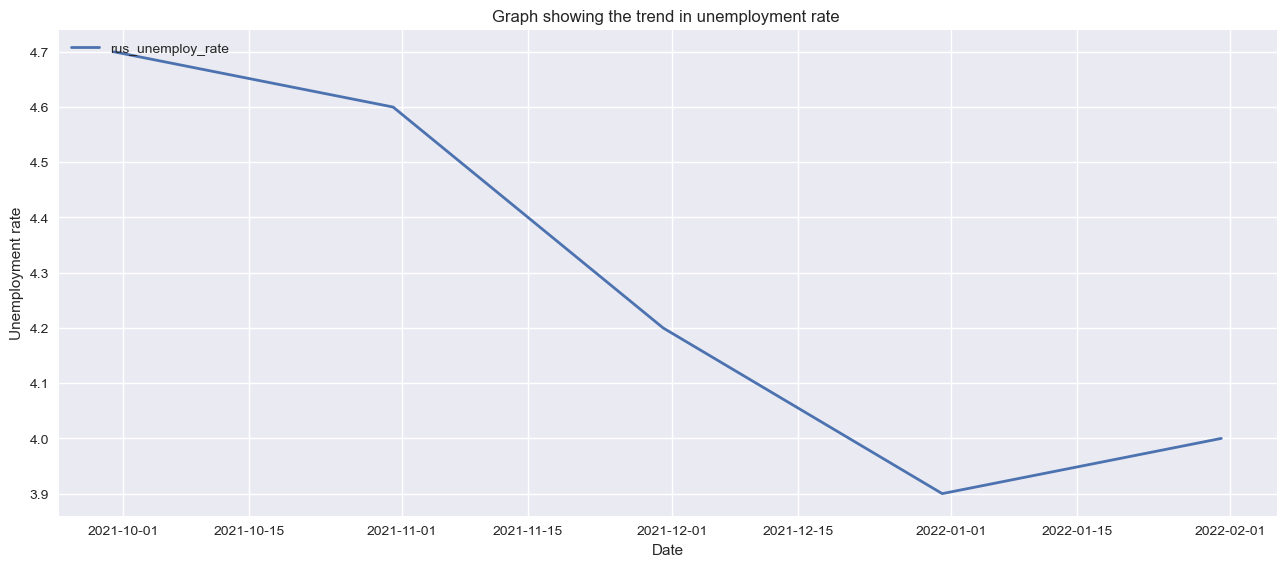

In [125]:
## graph showing the unemployment trend in from 6 months before the uk-russian invasion
rus_df = rus_unemp_df[['rus_unemploy_rate']].copy()

plot_graph(rus_df, title="Graph showing the trend in unemployment rate", y_label="Unemployment rate")

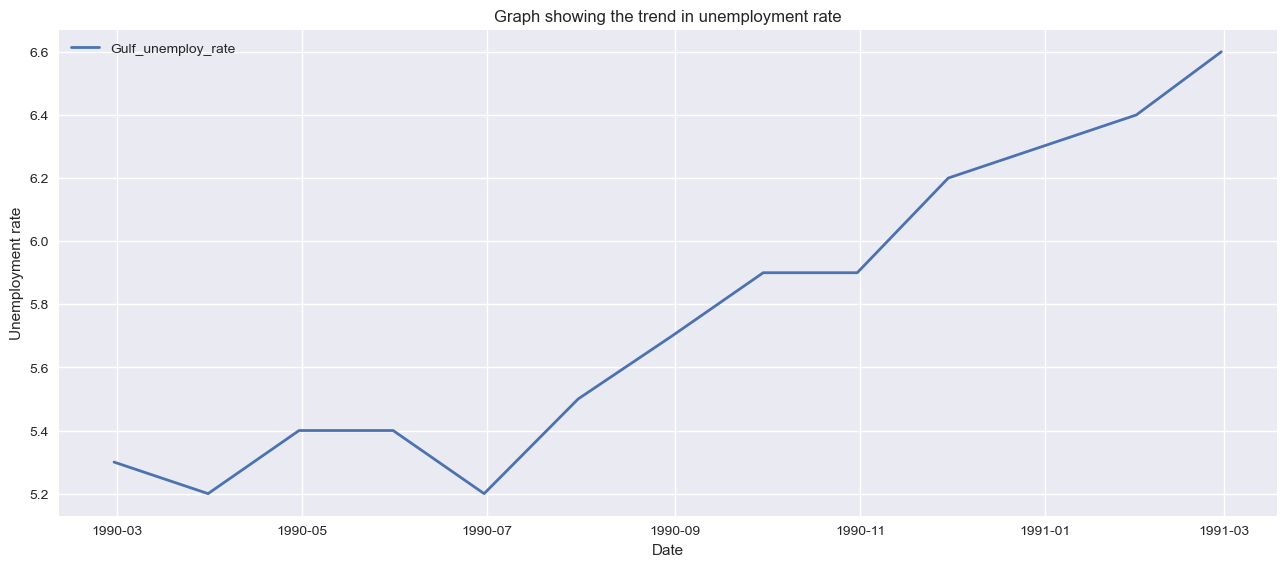

In [126]:
gulf_unemp_df = gulf_unemp_df[['Gulf_unemploy_rate']].copy()

plot_graph(gulf_unemp_df, title="Graph showing the trend in unemployment rate", y_label="Unemployment rate")

In [97]:
## function to fetch data from the yfinance

def exchange_data(start_date, end_date):
    
    tickers = ['LMT', 'BA', 'RTX', 'NOC', 'GD']

    ### looping through the tickers list to get their respective 'close' data during the gulf war period
    
    for id, ticker in enumerate(tickers):

        ## Getting the exchange object
        t_object = yf.Ticker(ticker)

        ## getting the data, cleaning it and reorganizing it. 
        hist = t_object.history(start=start_date, end=end_date)

        df = hist[['Close']].copy()

        df.rename(columns= {'Close': f"{ticker}_Close"}, inplace=True)

        df.reset_index(inplace=True)

        if id==0: 
            exchange_df = df
        else: 
            exchange_df = pd.merge(exchange_df, df, how="outer")
            
    return exchange_df

In [115]:
gulf_df = exchange_data("1990-02-01","1991-02-28")

## getting the current date for the  russian-ukraine invasion as it is not yet over
current_date_str = current_date.strftime("%Y-%m-%d")

rus_ukr_df = exchange_data("2021-09-01", current_date_str)

gulf_df.set_index('Date', inplace =True)

rus_ukr_df.set_index('Date', inplace=True)



,Date,LMT_Close,BA_Close,RTX_Close,NOC_Close,GD_Close
0,2021-08-31,352.205109,219.500000,83.302101,363.299561,195.828354
1,2021-09-01,349.131439,218.119995,82.653450,360.612122,195.319992
2,2021-09-02,350.492035,220.830002,83.085892,363.892365,197.773834
3,2021-09-03,348.485321,218.169998,82.211205,361.550720,197.930252
4,2021-09-07,341.828857,214.240005,81.572380,354.585114,197.861801
...,...,...,...,...,...,...
226,2022-07-26,396.809998,155.919998,90.239998,444.649994,217.630005
227,2022-07-27,398.540009,156.089996,90.269997,445.809998,219.850006
228,2022-07-28,406.079987,159.089996,92.389999,454.459991,223.800003
229,2022-07-29,413.809998,159.309998,93.209999,478.899994,226.669998


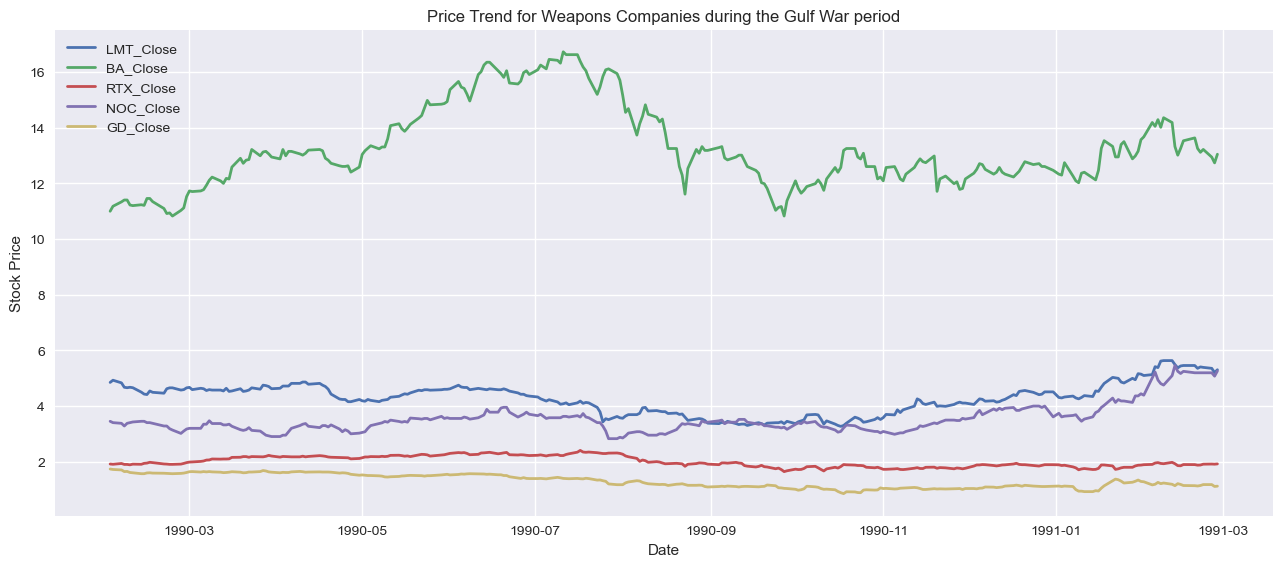

In [121]:
## graph showing the price trends for weapons Companies during the gulf War period
## LMT : Lockheed Martin Corp
## BA : Boeing
## RTX: Raytheon
## NOC: Northrop Grumman Corp
## GD: General Dynamics Corp
plot_graph(gulf_df, title="Price Trend for Weapons Companies during the Gulf War period", y_label="Stock Price")

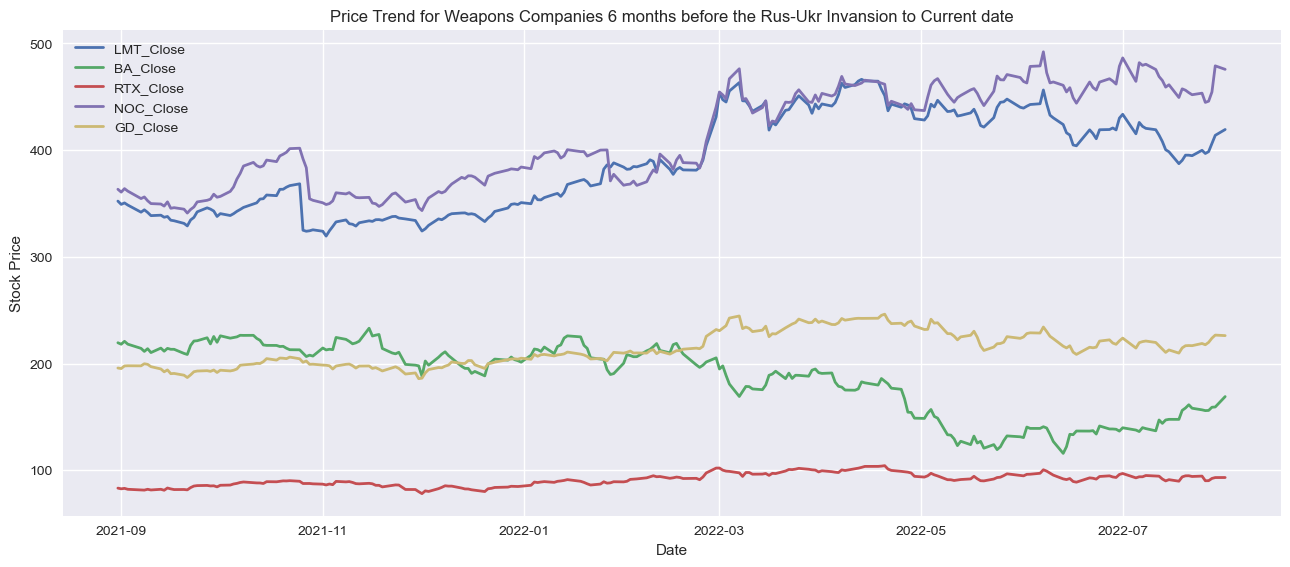

In [120]:
## graph showing the price trends for weapons Companies at the present time

plot_graph(rus_ukr_df, title="Price Trend for Weapons Companies 6 months before the Rus-Ukr Invansion to Current date", y_label="Stock Price" )